In [1]:
#ENVIRONMENT
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

import random
import json
import pickle
from PIL import Image
from IPython.display import display
from sklearn.manifold import TSNE
from scipy.spatial import distance
import pandas as pd
import hdbscan
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from random import choices
from sklearn.metrics.cluster import contingency_matrix

Using TensorFlow backend.


In [265]:
#DEFINITIONS
archs = {
    'VGG16',
    'Xception',
    'ResNet34'
}
arch = 'VGG16'#keras, 
def load_image(path, arch):
    img = image.load_img(path) if arch=='Xception' else image.load_img(path, target_size=model.input_shape[1:3])
    #img = image.load_img(path, target_size=model.input_shape[1:3]) #VGG16, Resnet
    #img = image.load_img(path) #XCeption
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x
PATH = '/media/s/DATA/Downloads/bigserene-sulimon-master/2019-07-10/images/'
tPATH = '/media/s/DATA/Downloads/bigserene-sulimon-master/2019-07-10/images/'
# This is the code you would run to load your own image-files.
# It has been commented out so it won't run now.

from dataset import load_cached
dataset = load_cached(cache_path=f'{PATH}my_dataset_cache.pkl', in_dir=f'{PATH}')
num_classes = dataset.num_classes
images = list(dataset.get_paths())
cls = dataset.class_numbers
brands = dataset.class_names
def get_VGG16():
    model = tf.keras.applications.VGG16(weights='imagenet')
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    return model, feat_extractor
def get_Xception():
    model = tf.keras.applications.Xception(weights='imagenet')
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
    return model,feat_extractor
def get_ResNet50():
    model = tf.keras.applications.ResNet50(weights='imagenet')
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
    return model, feat_extractor
def getModel(x):
    return{
        'VGG16': get_VGG16(),
        'Xception':get_Xception(),
        'ResNet50':get_ResNet50()
    }.get(x,'VGG16')

#Function to plot an embedding along with the clustering
def plot_clustered_embedding(embedding,classes):
     plt.scatter(embedding[:,0],embedding[:,1], c=classes, s=.1, cmap='nipy_spectral')

#Maps one clustering to another. 
#Input: Two different clusterings of the same data.
#Output: The second clustering only using the corresponding labels from the first one
#The first clustering true_labels is treated as the true clustering, and labeling2 is converted to the label
#indices in true_labels
#Uses the contingency matrix method, i.e. if a high percentage of images in cluster 3 from the first clustering
#fall into cluster 7 in the second clustering, then replace all 7's in the second clustering with 3's.
def map_clustering(true_labels,labeling2):
    cont=contingency_matrix(true_labels,labeling2)
    max_conts=np.amax(cont,1)
    true_cluster=np.array(max_conts)
    for i in range(0,len(max_conts)):
        curr_true=np.argwhere(cont[i]==max_conts[i])
        true_cluster[i]=curr_true if len(curr_true)<=1 else np.min(curr_true)
        new_labels=np.array(labeling2)
    for j in range(0,len(labeling2)):
        curr_label=np.argwhere(true_cluster==labeling2[j])
        if len(curr_label)>=1:
            new_labels[j]=np.min(curr_label)
        else:
            new_labels[j]=-1
    return new_labels

#Compute the F1 score of the clusters. Each cluster has one F1 score. If the cluster is not detected with the
#second clustering, the F1 score for that cluster is 0. The return value is the mean F1 score for all clusters
#This can be instead weighted by cluster size if the larger clusters are more important to be robust
def clustering_f1_score(clustering_s,new_labels):
    new_cont=contingency_matrix(clustering_s,new_labels)
    F1=np.zeros([max(clustering_s)+1])
    for i in range(0,min(np.shape((new_cont)))):
        TP=new_cont[i,i]
        P = np.sum(clustering_s==i)
        F = np.sum(clustering_s!=i)
        FP = np.sum(new_cont[:,i])-TP
        FN=P-TP
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        if precision >0 and recall > 0:
            curr_F1=2*precision*recall/(precision+recall)
        else:
            curr_F1=0
        
        F1[i]=curr_F1 if not np.isnan(curr_F1) else 0
    return np.mean(F1)

#Validates a clusterer using the above functions. The steps are as follows:
#Compute the clustering for all data, treat this as the "true" clustering
#For each subset of the data, predict which cluster it would fall in with the true clustering,
#Then, compute a clustering on the subset itself. Calculate how well the subset clustering corresponds to the 
#"true" clustering by computing F1 score
def validate_cluster_method(clusterer,feature_set,subset_size,num_subsets):
    true_clustering =clusterer.fit(feature_set)
    mean_F1=np.empty(num_subsets)
    for i in range(0,num_subsets):
        subset=choices(feature_set,k=subset_size)
        true_clustering_s=true_clustering.predict(subset)
        clustering_s = clusterer.fit(subset)
        new_labels = map_clustering(true_clustering_s,clustering_s.labels_)
        mean_F1[i]=clustering_f1_score(true_clustering_s,new_labels)
    return mean_F1

Creating dataset from the files in: /media/s/DATA/Downloads/bigserene-sulimon-master/2019-07-10/images/
- Data loaded from cache-file: /media/s/DATA/Downloads/bigserene-sulimon-master/2019-07-10/images/my_dataset_cache.pkl


In [3]:
model, feat_extractor = getModel(arch)

In [4]:
#Extract features from images
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 50 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path, arch);
    feat = feat_extractor.predict(x, batch_size=64)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 12058. Time: 0.0002 seconds.
analyzing image 50 / 12058. Time: 2.0981 seconds.
analyzing image 100 / 12058. Time: 0.8413 seconds.
analyzing image 150 / 12058. Time: 0.8359 seconds.
analyzing image 200 / 12058. Time: 0.8548 seconds.
analyzing image 250 / 12058. Time: 0.9004 seconds.
analyzing image 300 / 12058. Time: 0.9663 seconds.
analyzing image 350 / 12058. Time: 0.9513 seconds.
analyzing image 400 / 12058. Time: 1.0182 seconds.
analyzing image 450 / 12058. Time: 0.9372 seconds.
analyzing image 500 / 12058. Time: 0.9906 seconds.
analyzing image 550 / 12058. Time: 1.0439 seconds.
analyzing image 600 / 12058. Time: 1.0479 seconds.
analyzing image 650 / 12058. Time: 1.0453 seconds.
analyzing image 700 / 12058. Time: 1.0498 seconds.
analyzing image 750 / 12058. Time: 0.9918 seconds.
analyzing image 800 / 12058. Time: 1.0124 seconds.
analyzing image 850 / 12058. Time: 0.9789 seconds.
analyzing image 900 / 12058. Time: 1.0248 seconds.
analyzing image 950 / 12058. Time:

analyzing image 7900 / 12058. Time: 1.1683 seconds.
analyzing image 7950 / 12058. Time: 1.1430 seconds.
analyzing image 8000 / 12058. Time: 1.1596 seconds.
analyzing image 8050 / 12058. Time: 1.2135 seconds.
analyzing image 8100 / 12058. Time: 1.1944 seconds.
analyzing image 8150 / 12058. Time: 1.1512 seconds.
analyzing image 8200 / 12058. Time: 1.1906 seconds.
analyzing image 8250 / 12058. Time: 1.1671 seconds.
analyzing image 8300 / 12058. Time: 1.1900 seconds.
analyzing image 8350 / 12058. Time: 1.1433 seconds.
analyzing image 8400 / 12058. Time: 1.1611 seconds.
analyzing image 8450 / 12058. Time: 1.1820 seconds.
analyzing image 8500 / 12058. Time: 1.0575 seconds.
analyzing image 8550 / 12058. Time: 1.1578 seconds.
analyzing image 8600 / 12058. Time: 1.1701 seconds.
analyzing image 8650 / 12058. Time: 1.2424 seconds.
analyzing image 8700 / 12058. Time: 1.1721 seconds.
analyzing image 8750 / 12058. Time: 1.1500 seconds.
analyzing image 8800 / 12058. Time: 1.2196 seconds.
analyzing im

In [246]:
#The full data set is a bit high dimensional, so I'm reducing to the for most 'important' features based on 
#feature variance
#Later I can apply much more advanced data mining / feature engineering to find the most important features or 
#combinations of features for clustering
features=np.array(features)
variances=features.var(0)
feature_set=np.squeeze(features[:,np.argwhere(variances>6)])
np.shape(feature_set)


#     2) use contingency matrix to map which clusters go to which
#    


(12058, 4)

In [254]:
#First try Kmeans with only 3 clusters on the important features chosen above. Compute the mean_F1 defined above
#over 3 clusters for 100 subsets of size 1000
clusterer= KMeans(n_clusters=3, random_state=0)
num_subsets=100
subset_size=1000
mean_F1_5=validate_cluster_method(clusterer,feature_set,subset_size,num_subsets)

#Next try the same scoring for 20 clusters
clusterer= KMeans(n_clusters=20, random_state=0)
num_subsets=100
subset_size=1000
mean_F1_20=validate_cluster_method(clusterer,feature_set,subset_size,num_subsets)
#toc = time.clock()
#elap = toc-tic;


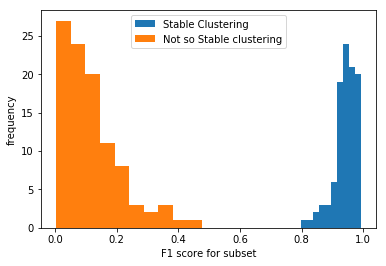

In [258]:
#Plot the result. The 5 clusters provides a much more stable clustering in that the F1 score is higher. 
#This means that the clusterings on subsets correspond well with clustering on the full data
plt.hist(mean_F1_5)
plt.hist(mean_F1_20)
plt.legend(('Stable Clustering','Not so Stable clustering'))
plt.xlabel('F1 score for subset')
plt.ylabel('frequency')
plt.show()

In [264]:
#Now use this techinque to find the "best" number of clusters parameter for Kmeans
#We can use this metric to search clustering methods and parameters to find the most "robust" clusterings

num_subsets=100
subset_size=1000
max_num_clust=50
min_num_clust=2
all_mean=np.empty(max_num_clust)
for i in range(min_num_clust,max_num_clust):
    clusterer=KMeans(n_clusters=i, random_state=0)
    mean_F1=validate_cluster_method(clusterer,feature_set,subset_size,num_subsets)
#toc = time.clock()
#elap = toc-tic;
    all_mean[i]=np.mean(mean_F1)


Text(0, 0.5, 'mean F1 score')

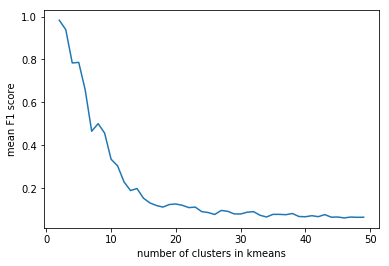

In [266]:
#The result: Fewer clusters results in more robust clusters, which may be expected for kmeans. The 
#idea is to apply this metric to other clustering algorithms over different parameter sets. See notes below

plt.plot(range(min_num_clust,max_num_clust),all_mean[min_num_clust:max_num_clust])
plt.xlabel('number of clusters in kmeans')
plt.ylabel('mean F1 score')


In [ ]:
#We can discuss and define other metrics that are desirable for the clusterings since Stability is
#not the only thing we desire in clusterings. 
#I would suggest defining 2 or more metrics, this F1 score (i.e."stability") being one of them
#After we define metrics, we can do a Bayesian search over all parameter ranges for many clustering algorithms
#To find the most desirable clustering by optimizing our metrics